In [2]:
import tqdm
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from torch.nn import init
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import functional as FT

In [3]:
train = CIFAR10(
    'data', 
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]), 
    download=True
)
train_dl = DataLoader(train, 32, shuffle=True, num_workers=4, drop_last=True)

test = CIFAR10(
    'validate', 
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]), 
    download=True
)
test_dl = DataLoader(test, 32, shuffle=False, num_workers=4, drop_last=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting validate/cifar-10-python.tar.gz to validate


In [4]:
LATENT_SPACE_DIM = 24

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(16)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64)
        )
            
        
        self.fc1 = nn.Linear(8 * 8 * 64, 128)
        self.fc_bn1 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, LATENT_SPACE_DIM)
        self.fc_bn2 = nn.BatchNorm1d(LATENT_SPACE_DIM)
    
    def forward(self, x):        
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(-1, 8 * 8 * 64)

        x = F.relu(self.fc_bn1(self.fc1(x)))
        x = F.relu(self.fc_bn2(self.fc2(x)))
        return x

In [5]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(LATENT_SPACE_DIM, 128)
        self.fc_bn1 = nn.BatchNorm1d(128)

        self.fc2 = nn.Linear(128, 64 * 8 * 8)
        self.fc_bn2 = nn.BatchNorm1d(64 * 8 * 8)

        self.conv1 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.conv2 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(3)
        )
    
    def forward(self, z):
        x = F.relu(self.fc_bn1(self.fc1(z)))
        x = F.relu(self.fc_bn2(self.fc2(x))).view(-1, 64, 8, 8)
        
        x = self.conv1(x)
        x = self.conv2(x)
        
        return F.sigmoid(x)

In [6]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.enc_mu = nn.Linear(LATENT_SPACE_DIM, LATENT_SPACE_DIM)
        self.enc_logvar = nn.Linear(LATENT_SPACE_DIM, LATENT_SPACE_DIM)

    def forward(self, x):
        h = self.encoder(x)
        
        mu, logvar = self.enc_mu(h), self.enc_logvar(h)
        sigma = (logvar * 0.5).exp_()
        z = mu + sigma * torch.randn_like(sigma)
        
        xh = self.decoder(z)
        
        return (mu, sigma), xh
    
    def sample(self, n=1):
        z = torch.randn(n, LATENT_SPACE_DIM, 
                        dtype=torch.float)
        
        xh = self.decoder(z)
        xh = xh.detach()
        
        return xh

In [5]:
def latent_loss(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

In [6]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
# device_cpu = torch.device("cpu")

In [14]:
model = VAE(Encoder(), Decoder())
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model = model.to(device)

In [15]:
model = model.to(device)

In [11]:
model.train()

for epoch in tqdm.tqdm_notebook(range(1, 25)):
    total_loss = 0
    for x, _ in tqdm.tqdm_notebook(train_dl):
        x = x.to(device)
        h, xh = model(x)
        loss = F.binary_cross_entropy(xh, x) + latent_loss(*h)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    total_loss /= len(train_dl)
    print(f'i_epoch={epoch} loss={total_loss}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/24 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/1562 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


i_epoch=1 loss=0.6739499604808842


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=2 loss=0.6075972587289945


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=3 loss=0.6031520155648415


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=4 loss=0.600245823284728


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=5 loss=0.598000223253509


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=6 loss=0.5967686860875803


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=7 loss=0.5953308186289901


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=8 loss=0.5946728237994043


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=9 loss=0.5937878333804855


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=10 loss=0.5925317309730032


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=11 loss=0.5918403052642617


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=12 loss=0.5914098347194979


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=13 loss=0.5912449617086696


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=14 loss=0.5907365490471355


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=15 loss=0.5903921702759825


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=16 loss=0.5908267635771011


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=17 loss=0.5897583751611306


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=18 loss=0.5895665089543742


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=19 loss=0.5892521946973593


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=20 loss=0.5888910407675061


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=21 loss=0.5887970945364992


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=22 loss=0.5886178454348433


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=23 loss=0.5885161743350279


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=24 loss=0.5883172729103879


In [27]:
model.eval()

VAE(
  (encoder): Encoder(
    (conv1): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fc1): Linear(in_features=4096, out_features=128, bias=True)
    (fc_bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=128, out_features=24, bias=True)
    (fc_bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Decoder(
 

In [13]:
def t2np(image):
    image = np.array(image.getdata(), np.uint8).reshape(image.size[1], image.size[0], 3)
    return image

In [28]:
model_cpu = model.to(device_cpu)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


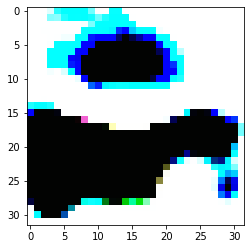

In [29]:
image = FT.to_pil_image(model_cpu.sample()[0])
image = t2np(image)
plt.imshow(image)

In [22]:
model_cpu.sample()[0]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.0325, 0.0325, 0.0325],
         [1.0000, 1.0000, 1.0000,  ..., 0.0325, 0.0325, 0.0325],
         [1.0000, 1.0000, 1.0000,  ..., 0.0325, 0.0325, 0.0325],
         ...,
         [0.0325, 0.0325, 0.0325,  ..., 0.0325, 0.0325, 0.0325],
         [0.0325, 0.0325, 0.0325,  ..., 0.0325, 0.0325, 0.0325],
         [0.0325, 0.0325, 0.0325,  ..., 0.0325, 0.0325, 0.1959]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.0359, 0.0359, 0.0359],
         [1.0000, 1.0000, 1.0000,  ..., 0.0359, 0.0359, 0.0359],
         [1.0000, 1.0000, 1.0000,  ..., 0.0359, 0.0359, 0.0359],
         ...,
         [0.0359, 0.0359, 0.0359,  ..., 0.3136, 0.4480, 0.7413],
         [0.0359, 0.0359, 0.0359,  ..., 0.9300, 0.8891, 0.9635],
         [0.0359, 0.0359, 0.0359,  ..., 0.9918, 0.9909, 0.9893]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.0302, 0.0302, 0.0302],
         [1.0000, 1.0000, 1.0000,  ..., 0.0302, 0.0302, 0.0302],
         [1.0000, 1.0000, 1.0000,  ..., 0.0302, 0.0302, 0.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


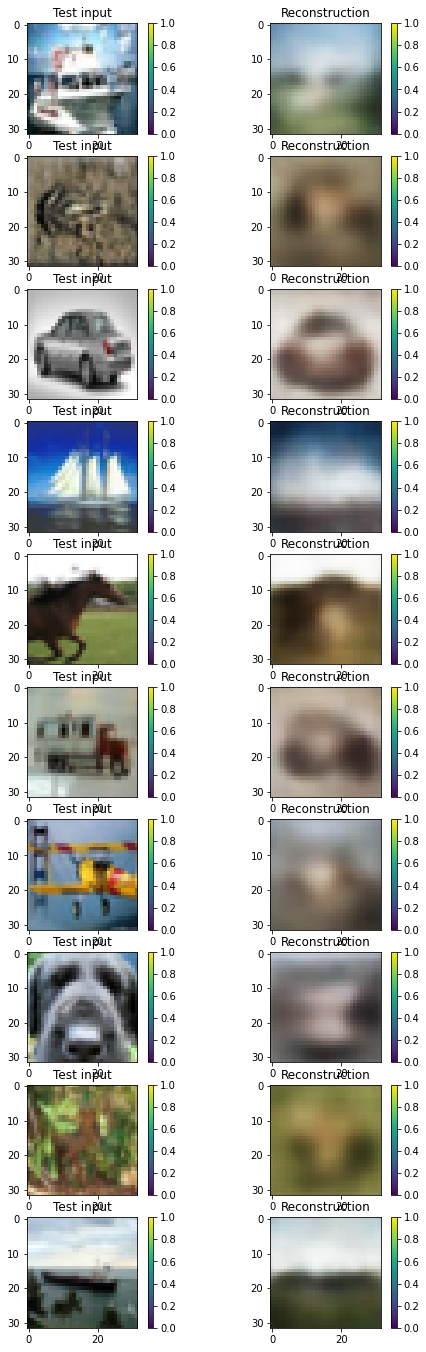

In [30]:
img = next(iter(train_dl))[0]
res = model_cpu(img)[1]
plot_images([FT.to_pil_image(img[i]) for i in range(len(img))], [FT.to_pil_image(res[i]) for i in range(len(img))])

In [23]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(16)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64)
        )
            
        
        self.fc1 = nn.Linear(8 * 8 * 64, 128)
        self.fc_bn1 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, LATENT_SPACE_DIM)
        self.fc_bn2 = nn.BatchNorm1d(LATENT_SPACE_DIM)

        self.fc3 = nn.Linear(LATENT_SPACE_DIM, 10)
    
    def forward(self, x):        
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(-1, 8 * 8 * 64)

        x = F.relu(self.fc_bn1(self.fc1(x)))
        x = F.relu(self.fc_bn2(self.fc2(x)))
        supervised = self.fc3(x)
        return x, supervised

In [24]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(LATENT_SPACE_DIM, 128)
        self.fc_bn1 = nn.BatchNorm1d(128)

        self.fc2 = nn.Linear(128, 64 * 8 * 8)
        self.fc_bn2 = nn.BatchNorm1d(64 * 8 * 8)

        self.conv1 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.conv2 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(3)
        )
    
    def forward(self, z):
        x = F.relu(self.fc_bn1(self.fc1(z)))
        x = F.relu(self.fc_bn2(self.fc2(x))).view(-1, 64, 8, 8)
        
        x = self.conv1(x)
        x = self.conv2(x)
        
        return F.sigmoid(x)

In [28]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.enc_mu = nn.Linear(LATENT_SPACE_DIM, LATENT_SPACE_DIM)
        self.enc_logvar = nn.Linear(LATENT_SPACE_DIM, LATENT_SPACE_DIM)

    def forward(self, x):
        h, supervised = self.encoder(x)
        
        mu, logvar = self.enc_mu(h), self.enc_logvar(h)
        sigma = (logvar * 0.5).exp_()
        z = mu + sigma * torch.randn_like(sigma)
        
        xh = self.decoder(z)
        
        return (mu, sigma), xh, supervised
    
    def sample(self, n=1):
        z = torch.randn(n, LATENT_SPACE_DIM, 
                        dtype=torch.float)
        
        xh = self.decoder(z)
        xh = xh.detach()
        
        return xh

In [22]:
criterion = nn.CrossEntropyLoss()

model.train()

for epoch in tqdm.tqdm_notebook(range(1, 25)):
    total_loss = 0
    for x, y in tqdm.tqdm_notebook(train_dl):
        x = x.to(device)
        y = y.long().to(device)
        h, xh, supervised = model(x)
        loss = F.binary_cross_entropy(xh, x) + latent_loss(*h) + criterion(supervised, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    total_loss /= len(train_dl)
    print(f'i_epoch={epoch} loss={total_loss}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/35 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/1562 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


i_epoch=25 loss=0.7133059609256847


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=26 loss=0.7060523477314987


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=27 loss=0.7003152149129616


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=28 loss=0.6986453192411098


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=29 loss=0.7007594332194359


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=30 loss=0.6920066747943204


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=31 loss=0.690023618035982


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=32 loss=0.6976122166222097


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=33 loss=0.6864972473259314


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=34 loss=0.682895878938035


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=35 loss=0.6838706911144428


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=36 loss=0.6850373982696314


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=37 loss=0.6803121052005074


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=38 loss=0.6756974187001071


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=39 loss=0.6778940574841982


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=40 loss=0.6786101350558399


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=41 loss=0.6729321570997812


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=42 loss=0.6764201600099801


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=43 loss=0.6703459823101033


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=44 loss=0.6723285695960061


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=45 loss=0.6699044282396686


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=46 loss=0.6670355319442578


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=47 loss=0.6678498444957098


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=48 loss=0.6657614540427962


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=49 loss=0.6652310937833847


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=50 loss=0.6651564596099219


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=51 loss=0.6628211684019404


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=52 loss=0.6603871049710028


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=53 loss=0.6674962683310124


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=54 loss=0.6582975601646263


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=55 loss=0.6597431369612372


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=56 loss=0.6606299027743321


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=57 loss=0.6603778923901034


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=58 loss=0.6586869710080907


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=59 loss=0.6583842110847542


In [29]:
model = VAE(Encoder(), Decoder())
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model = model.to(device)

In [30]:
criterion = nn.CrossEntropyLoss()

model.train()

for epoch in tqdm.tqdm_notebook(range(1, 60)):
    total_loss = 0
    without_total_loss = 0
    for x, y in tqdm.tqdm_notebook(train_dl):
        x = x.to(device)
        y = y.long().to(device)
        h, xh, supervised = model(x)
        loss = F.binary_cross_entropy(xh, x) + latent_loss(*h) + criterion(supervised, y)

        without_supervised_loss = F.binary_cross_entropy(xh, x) + latent_loss(*h)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        without_total_loss += without_supervised_loss.item()
    
    total_loss /= len(train_dl)
    without_total_loss /= len(train_dl)
    print(f'i_epoch={epoch} loss={total_loss} without_loss={without_total_loss}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/59 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1562 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


i_epoch=1 loss=2.009019689279085 without_loss=0.7067410376175723


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=2 loss=1.5640101711362333 without_loss=0.6390144722333485


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=3 loss=1.3921257188775018 without_loss=0.6342715496977221


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=4 loss=1.2597459448971302 without_loss=0.6330038881103452


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=5 loss=1.1432083637171 without_loss=0.6327695231049986


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=6 loss=1.056070932772645 without_loss=0.6325013988607213


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=7 loss=0.9789048629060445 without_loss=0.6324338980887214


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=8 loss=0.9342374756607905 without_loss=0.6320199300171319


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=9 loss=0.8867833691430916 without_loss=0.6319073313100695


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=10 loss=0.8524706036272184 without_loss=0.6317172891122889


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=11 loss=0.8327992655022044 without_loss=0.6316265082618796


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=12 loss=0.8095210293419993 without_loss=0.6314354417571337


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=13 loss=0.7920118700832167 without_loss=0.6311499355086596


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=14 loss=0.781619529565379 without_loss=0.6308697958532887


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=15 loss=0.773933069730385 without_loss=0.6305413921190743


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=16 loss=0.7616474037744324 without_loss=0.6306327983985026


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=17 loss=0.7608049832828219 without_loss=0.6301219596142348


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=18 loss=0.7435057483775668 without_loss=0.629962372604314


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=19 loss=0.7408110666137652 without_loss=0.6295622870726714


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=20 loss=0.7322713326705708 without_loss=0.629015636199873


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=21 loss=0.7301538177550068 without_loss=0.6287704053288385


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=22 loss=0.7262067555160132 without_loss=0.6285598547067899


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=23 loss=0.7175102519699004 without_loss=0.6282204678437163


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=24 loss=0.711471305194188 without_loss=0.62795371679582


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=25 loss=0.7168797041634134 without_loss=0.6277619965479407


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=26 loss=0.7114127621379003 without_loss=0.6273110707346516


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=27 loss=0.7058920038341713 without_loss=0.6271315777576535


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=28 loss=0.7029966805106393 without_loss=0.6267136231198354


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=29 loss=0.7029178173456546 without_loss=0.626605037881226


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=30 loss=0.6953886559617046 without_loss=0.626250847429991


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=31 loss=0.6968433123926194 without_loss=0.6262054372001702


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=32 loss=0.6901109761602595 without_loss=0.6257321741455801


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=33 loss=0.6901339231471552 without_loss=0.6252504436444687


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=34 loss=0.6909418000759755 without_loss=0.62518428519807


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=35 loss=0.6859612283648663 without_loss=0.624929941494242


  0%|          | 0/1562 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f689013b7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


i_epoch=36 loss=0.6887775204703689 without_loss=0.6246611627436478


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=37 loss=0.6832167429136405 without_loss=0.6246473996419455


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=38 loss=0.6845129017793262 without_loss=0.624558317867345


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=39 loss=0.6792991925293291 without_loss=0.6240534463780485


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=40 loss=0.6767998153055218 without_loss=0.6241835242807483


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=41 loss=0.6775006244338276 without_loss=0.623750680654516


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=42 loss=0.672895434494971 without_loss=0.6235224081825813


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=43 loss=0.6775806843471283 without_loss=0.6232375012240856


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=44 loss=0.6703883258389755 without_loss=0.6233892078283654


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=45 loss=0.6716962657802084 without_loss=0.622941339328866


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=46 loss=0.6684320525536922 without_loss=0.6225128161235595


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=47 loss=0.6704258412008249 without_loss=0.6224088861145527


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=48 loss=0.668927940875101 without_loss=0.6222268169347517


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=49 loss=0.6670690318152175 without_loss=0.6219653400584159


  0%|          | 0/1562 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [14]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(16)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64)
        )
            
        
        self.fc1 = nn.Linear(8 * 8 * 64, 128)
        self.fc_bn1 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, LATENT_SPACE_DIM)
        self.fc_bn2 = nn.BatchNorm1d(LATENT_SPACE_DIM)

        self.fc3 = nn.Linear(LATENT_SPACE_DIM, 10)
    
    def forward(self, x, latent,train=True):
        if train:        
            x = self.conv1(x)
            x = self.conv2(x)

            x = x.view(-1, 8 * 8 * 64)

            x = F.relu(self.fc_bn1(self.fc1(x)))
            x = F.relu(self.fc_bn2(self.fc2(x)))
            # print(x.shape)
            # print(x[0])
            supervised = self.fc3(x)
        else:
            supervised = self.fc3(latent)
        return supervised

In [31]:
# class Classifier(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc = nn.Linear(LATENT_SPACE_DIM, 10) 

#     def forward(self, x):
#         x = self.fc(x)
#         return x

In [32]:
# encoder_model = Encoder()
classifier = Classifier()
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)

In [33]:
# encoder_model = encoder_model.to(device)
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
classifier = classifier.to(device)

In [35]:
criterion = nn.CrossEntropyLoss()


for epoch in tqdm.tqdm_notebook(range(1, 30)):
    # encoder_model.train()
    classifier.train()


    total_loss = 0
    for x, y in tqdm.tqdm_notebook(train_dl):
        x = x.to(device)
        y = y.long().to(device)
        # latent = encoder_model(x)

        latent = torch.tensor([0.0536, 0.0000, 0.0000, 1.2100, 0.3845, 0.0000, 0.0000, 0.0000, 0.2376,
        0.0000, 2.0840, 0.0000, 0.9536, 0.0000, 1.1038, 0.0000, 0.0000, 0.0000,
        0.1664, 0.0000, 0.3583, 0.0000, 0.0000, 1.1742])

        latent.to(device)

        supervised = classifier(x, latent)
        loss = criterion(supervised, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    total_loss /= len(train_dl)
    print(f'i_epoch={epoch} loss={total_loss}')

    # encoder_model.eval()
    classifier.eval()
    with torch.no_grad():
        correct = 0
        total_val_loss = 0
        for val_img, val_label in test_dl:

            val_img = val_img.float().to(device)
            val_label = val_label.long().to(device)

            latent = torch.tensor([0.0536, 0.0000, 0.0000, 1.2100, 0.3845, 0.0000, 0.0000, 0.0000, 0.2376,
            0.0000, 2.0840, 0.0000, 0.9536, 0.0000, 1.1038, 0.0000, 0.0000, 0.0000,
            0.1664, 0.0000, 0.3583, 0.0000, 0.0000, 1.1742])

            latent.to(device)

            # latent = encoder_model(val_img)
            supervised = classifier(val_img, latent)

            val_loss = criterion(supervised, val_label)
            total_val_loss += val_loss.item()

            _, prediction = torch.max(supervised, 1)

            correct += np.mean((val_label==prediction).int().cpu().numpy())

        print('Epoch {}: Validation Accuracy is {}%'.format(epoch + 1, correct * 100 / len(test_dl)))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/29 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/1562 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


i_epoch=1 loss=0.8852973581123597
Epoch 2: Validation Accuracy is 72.09106914212548%


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=2 loss=0.7302435985867711
Epoch 3: Validation Accuracy is 71.8930057618438%


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=3 loss=0.6073947652086864
Epoch 4: Validation Accuracy is 80.94390204865557%


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=4 loss=0.5026462150692329
Epoch 5: Validation Accuracy is 87.11387644046094%


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=5 loss=0.41679456275285587
Epoch 6: Validation Accuracy is 90.57098271446863%


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=6 loss=0.35092656621554447
Epoch 7: Validation Accuracy is 91.82338348271446%


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=7 loss=0.2963447263929397
Epoch 8: Validation Accuracy is 94.80033610755441%


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=8 loss=0.2546285564311221
Epoch 9: Validation Accuracy is 93.53193021766965%


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=9 loss=0.22054666370182047
Epoch 10: Validation Accuracy is 93.75800256081946%


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=10 loss=0.19347931134840057
Epoch 11: Validation Accuracy is 97.51120358514724%


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=11 loss=0.18105070301118126
Epoch 12: Validation Accuracy is 98.10339308578745%


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=12 loss=0.16418832534490088
Epoch 13: Validation Accuracy is 98.12540012804098%


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=13 loss=0.1497346353955643
Epoch 14: Validation Accuracy is 98.27944942381562%


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=14 loss=0.13724056079837038
Epoch 15: Validation Accuracy is 98.48751600512163%


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=15 loss=0.12708563427932718
Epoch 16: Validation Accuracy is 98.71758962868118%


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=16 loss=0.12123713637857189
Epoch 17: Validation Accuracy is 98.15741037131882%


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=17 loss=0.1154753368347287
Epoch 18: Validation Accuracy is 98.63756402048655%


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=18 loss=0.1120043349223958
Epoch 19: Validation Accuracy is 98.50352112676056%


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=19 loss=0.10647588578770092
Epoch 20: Validation Accuracy is 99.11971830985915%


  0%|          | 0/1562 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [43]:
import copy
best_wts = copy.deepcopy(classifier.state_dict())
torch.save(best_wts, "/content/gdrive/MyDrive/project/classifier.pth")

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
model = VAE(Encoder(), Decoder())
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model = model.to(device)

In [20]:
criterion = nn.CrossEntropyLoss()

model.train()
classifier = Classifier()
path = "/content/gdrive/MyDrive/project/classifier.pth"
model_dict=torch.load(path)
classifier.load_state_dict(model_dict)
classifier = classifier.to(device)
classifier.eval()

for epoch in tqdm.tqdm_notebook(range(25, 60)):
    total_loss = 0
    without_total_loss = 0
    for x, y in tqdm.tqdm_notebook(train_dl):
        x = x.to(device)
        y = y.long().to(device)
        h, xh, latent = model(x)

        supervised = classifier(x, latent, train=False)
        # loss = criterion(supervised, y)

        # loss = F.binary_cross_entropy(xh, x) + latent_loss(*h)

        loss = F.binary_cross_entropy(xh, x) + latent_loss(*h)+ criterion(supervised, y)

        without_supervised_loss = F.binary_cross_entropy(xh, x) + latent_loss(*h)

        # print(criterion(supervised, y).item())

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        without_total_loss += without_supervised_loss.item()

        # break
    
    total_loss /= len(train_dl)
    without_total_loss /= len(train_dl)
    print(f'i_epoch={epoch} loss={total_loss} without_loss={without_total_loss}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/35 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1562 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


i_epoch=25 loss=0.7457077676447039 without_loss=0.6300952066685265


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=26 loss=0.740026043258159 without_loss=0.6299670473332595


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=27 loss=0.7326332699703041 without_loss=0.6298185643786505


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=28 loss=0.7305776442898373 without_loss=0.6296377281602306


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=29 loss=0.7256359278621503 without_loss=0.6293869347868442


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=30 loss=0.7228784556959716 without_loss=0.6292015990664498


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=31 loss=0.7220409126348899 without_loss=0.6290543929562831


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=32 loss=0.7171754302044379 without_loss=0.628958508505864


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=33 loss=0.7148353270470867 without_loss=0.6287413779813105


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=34 loss=0.7144630036570809 without_loss=0.6287441940909005


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=35 loss=0.712485093237038 without_loss=0.6285421164102958


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=36 loss=0.7098245465801254 without_loss=0.6286692314813446


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=37 loss=0.7029086393369756 without_loss=0.6281267812859539


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=38 loss=0.7047972415839817 without_loss=0.6277353291932813


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=39 loss=0.7023679413731364 without_loss=0.6275694958684387


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=40 loss=0.6977851375574949 without_loss=0.6274751222164164


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=41 loss=0.6981388296497921 without_loss=0.6272001754917043


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=42 loss=0.6952157286919949 without_loss=0.62701405498954


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=43 loss=0.691741531202033 without_loss=0.6268104785306811


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=44 loss=0.6902591222837549 without_loss=0.6267343676731315


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=45 loss=0.6904146718230962 without_loss=0.6266516265811138


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=46 loss=0.6911723727071789 without_loss=0.6265541121611674


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=47 loss=0.6863224863548132 without_loss=0.6262293273294476


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=48 loss=0.6895013767915865 without_loss=0.6263792933788861


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=49 loss=0.6826974787342717 without_loss=0.6260126557453952


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=50 loss=0.6853656470775604 without_loss=0.6258337704915549


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=51 loss=0.6821149998224041 without_loss=0.6256710589695221


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=52 loss=0.6834961711673517 without_loss=0.6254141903488339


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=53 loss=0.6838548393316672 without_loss=0.6252863251063949


  0%|          | 0/1562 [00:00<?, ?it/s]

KeyboardInterrupt: ignored